# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

<a id='shag_1'></a>

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc
from timeit import default_timer
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score,RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

In [2]:
try:
    contract = pd.read_csv('C:/Users/GarySeldon/Downloads/final_provider/final_provider/contract.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [3]:
#contract['End']=contract.loc[contract['EndDate']=='No']
#contract['End2']=contract.loc[contract['EndDate']=='No']
contract.loc[contract['EndDate']=='No','Client'] = 0
contract.loc[contract['EndDate']!='No','Client'] = 1
display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Client
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1.0


In [4]:
try:
    personal = pd.read_csv('C:/Users/GarySeldon/Downloads/final_provider/final_provider/personal.csv')
except:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
display(personal.head())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
try:
    internet = pd.read_csv('C:/Users/GarySeldon/Downloads/final_provider/final_provider/internet.csv')
except:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
display(internet.head())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
try:
    phone = pd.read_csv('C:/Users/GarySeldon/Downloads/final_provider/final_provider/phone.csv')
except:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
display(phone.head())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [7]:
for df_name in [contract,personal,internet,phone]:
    print(df_name.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Client              7043 non-null float64
dtypes: float64(2), object(7)
memory usage: 495.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
custom

Пропущенных значений нет, дубликатов тоже. Числовой формат имеет SeniorCitizen,MonthlyCharges. Нужно перевести TotalCharges тоже в числовой.

In [8]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'],errors='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Client              7043 non-null float64
dtypes: float64(3), object(6)
memory usage: 495.3+ KB


In [9]:
for df_name in [contract,personal,internet,phone]:
    for column_name in df_name.columns:
        if column_name != 'customerID':
            print(df_name[column_name].value_counts())

2014-02-01    366
2019-11-01    237
2019-09-01    237
2019-10-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64
20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
114.75     1
103.60     1
113.40     1
57.65      1
113.30     1
Name: MonthlyCharges, Length: 1585, dtype: int64
20.20      11
19.75       9
19.65       8
20.05       8
19.90       8
     

Нет слишком малого количества значений по какому-то признаку, то могло бы помешать анализу. Но строк с ушедшими клиентами в 3 раза меньше, чем с неушедшими: можно сделать апсепплинг. Объединим все таблицы в одну общую. После объединения замением получившиеся НаНы на No.

In [10]:
#увеличение выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 1]
    features_ones = features[target == 0]
    target_zeros = target[target == 1]
    target_ones = target[target == 0]

    features_upsampled = pd.concat([features_zeros] * repeat + [features_ones])
    target_upsampled = pd.concat([target_zeros] * repeat + [target_ones])
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [11]:
df = pd.merge(contract, personal, how ='left', on ='customerID') 
df = pd.merge(df, internet, how ='left', on ='customerID') 
df = pd.merge(df, phone, how ='left', on ='customerID') 
display(df.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Client,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0.0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [12]:
df[df.columns].fillna(value='No', inplace=True)
display(df.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Client,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0.0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


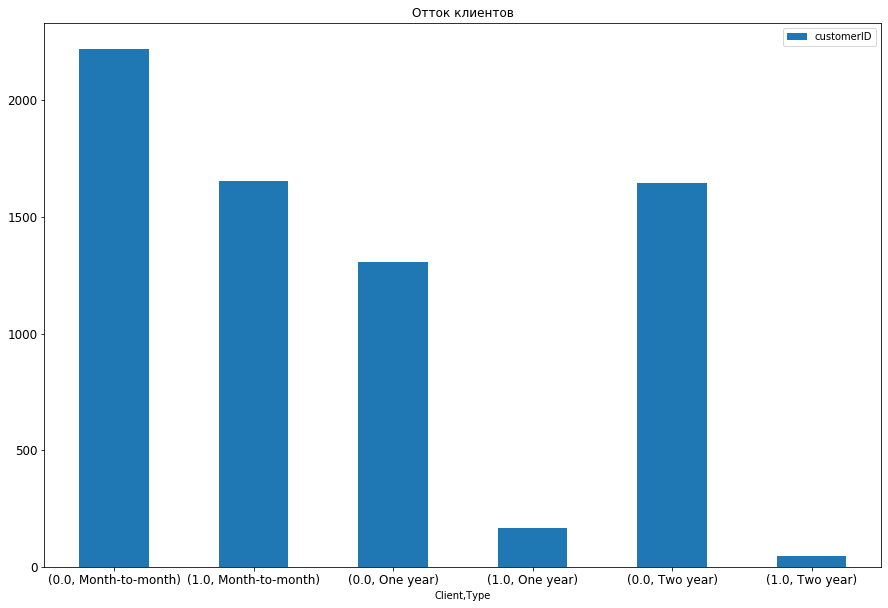

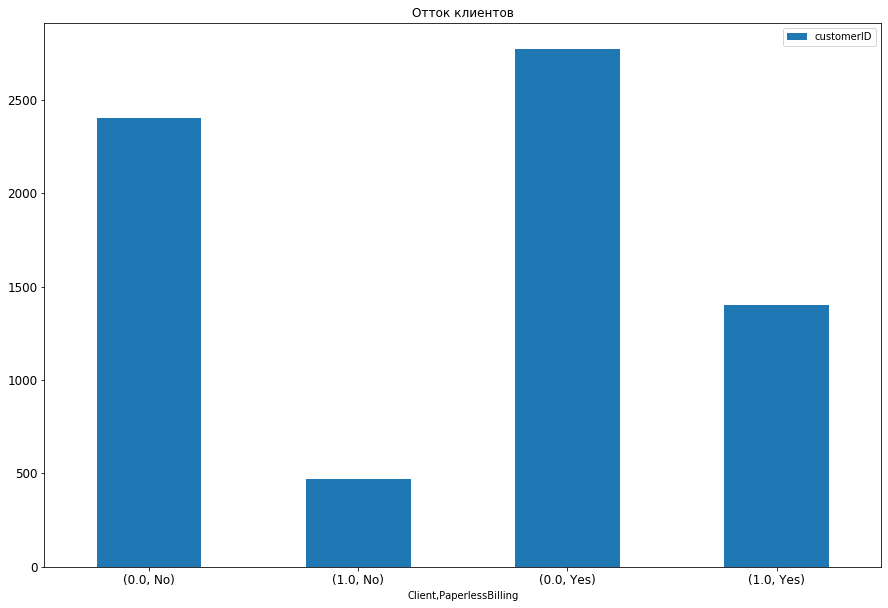

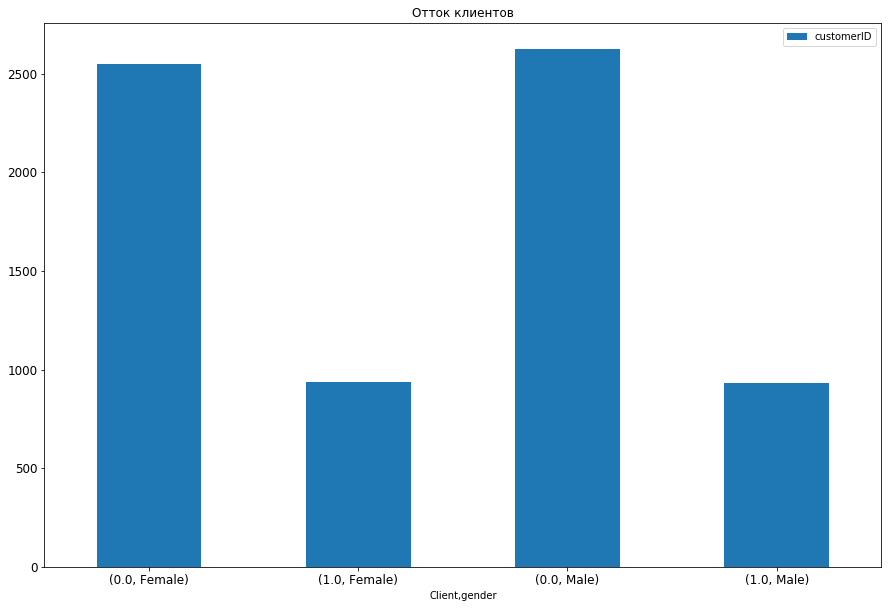

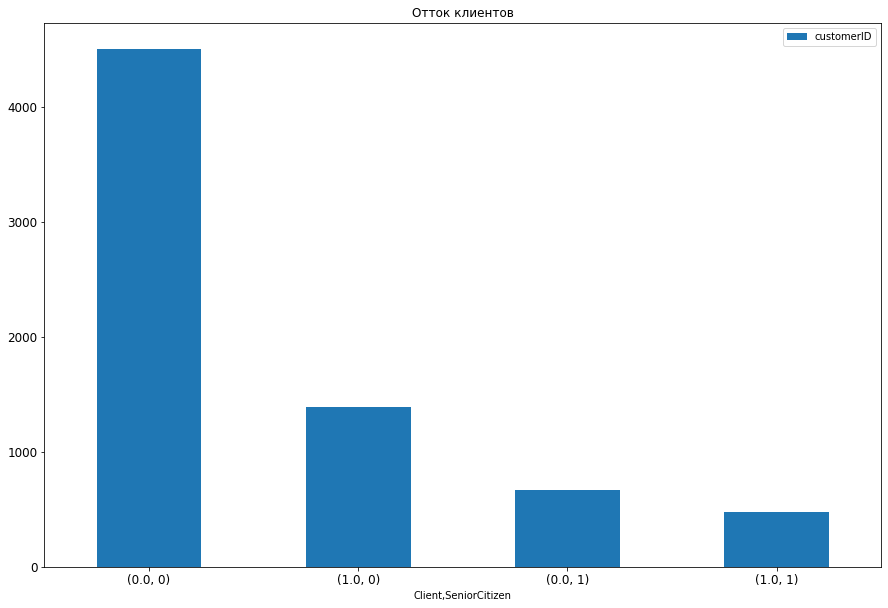

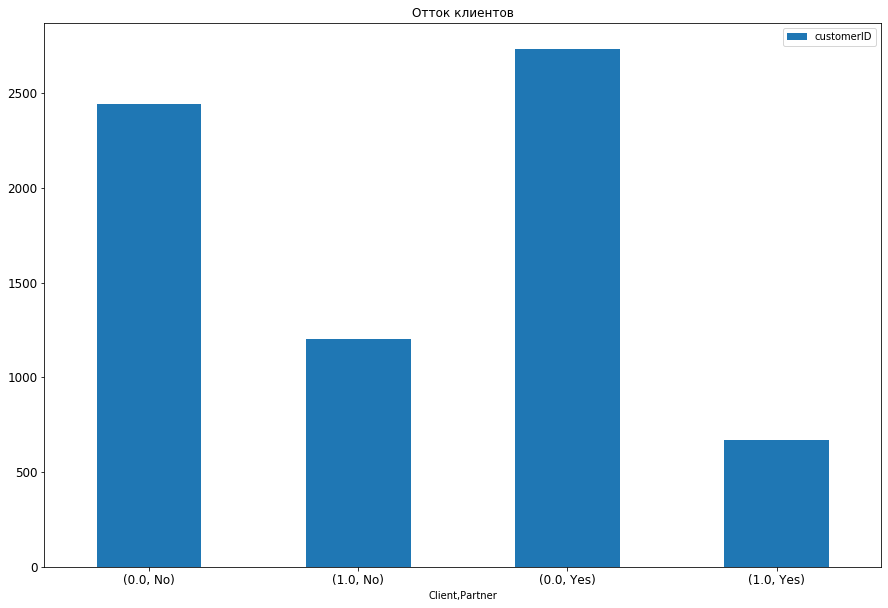

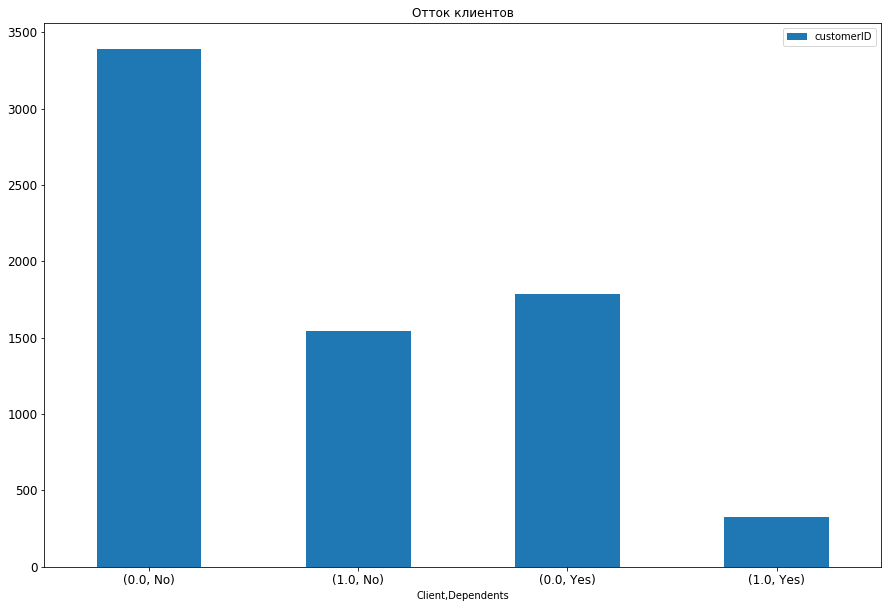

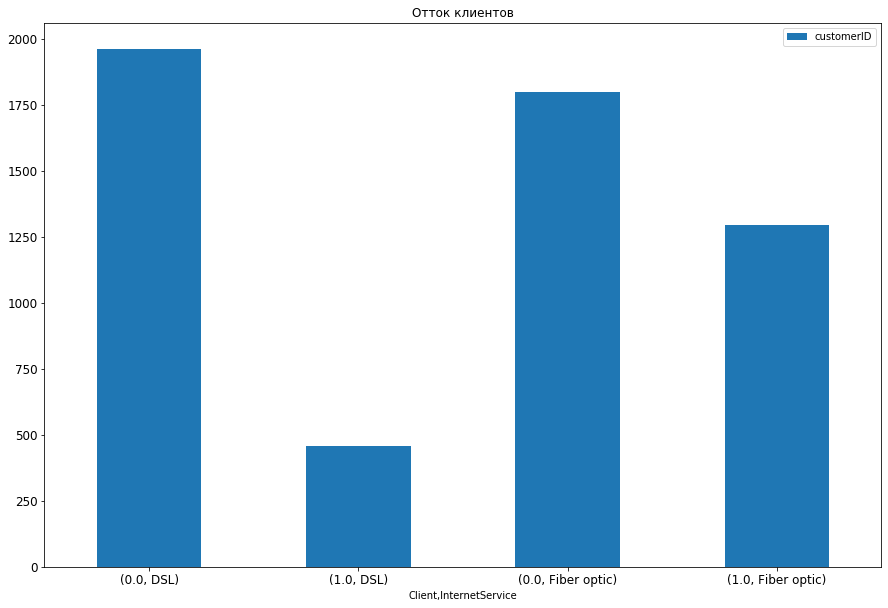

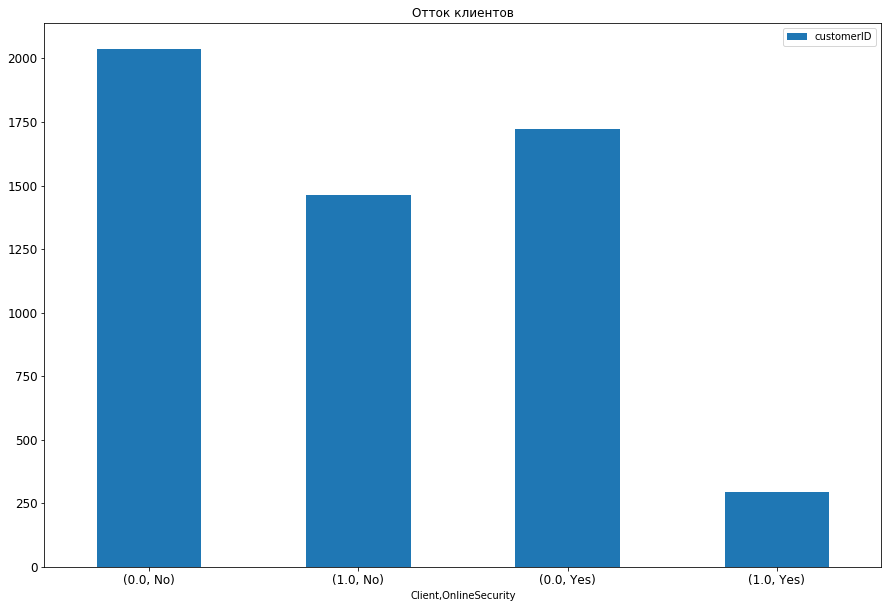

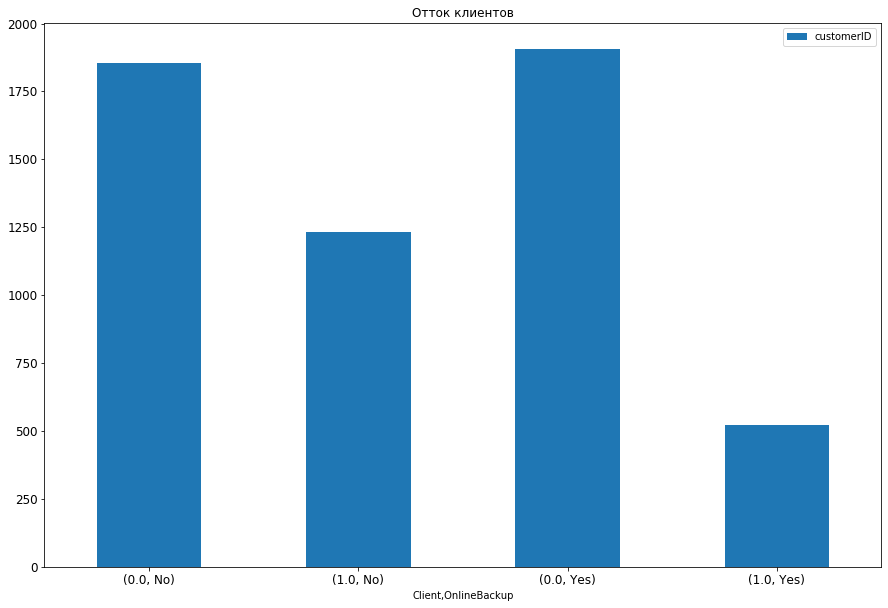

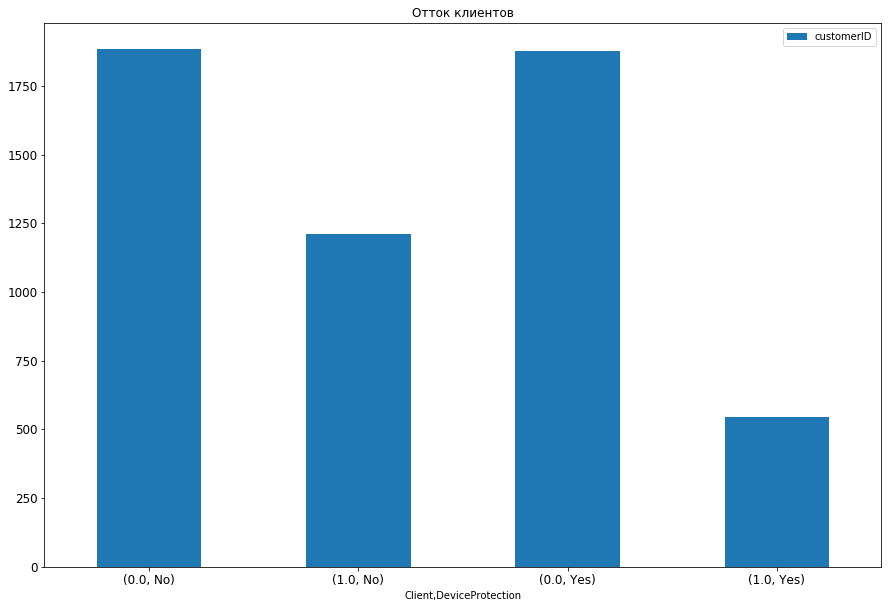

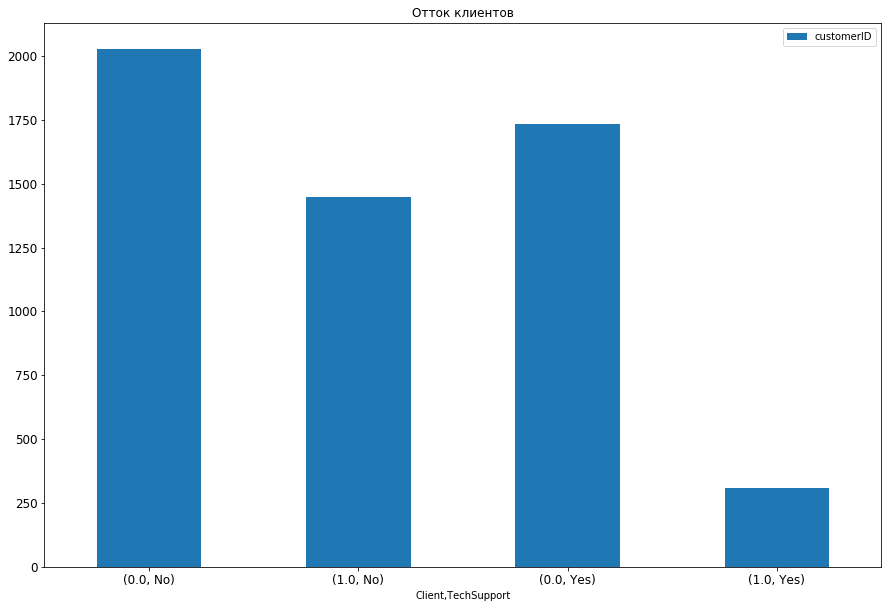

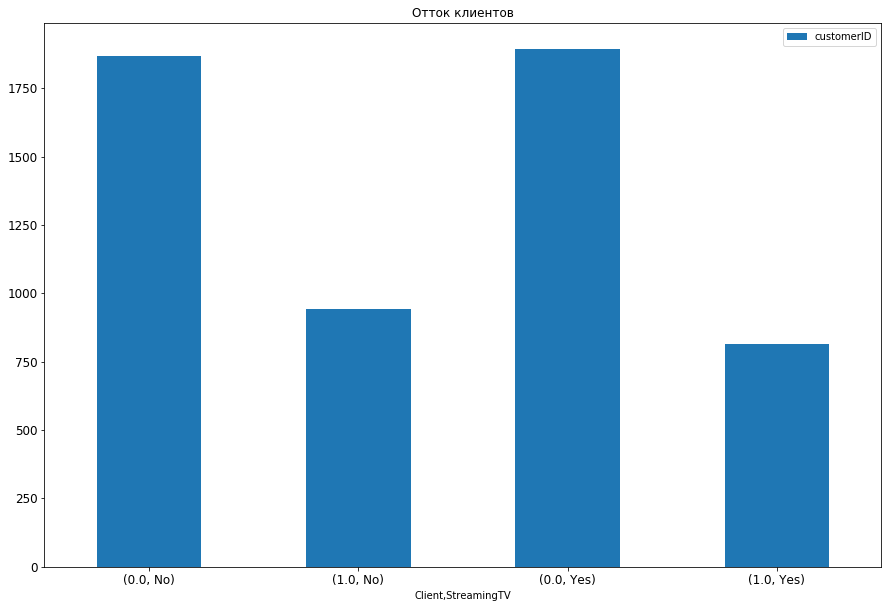

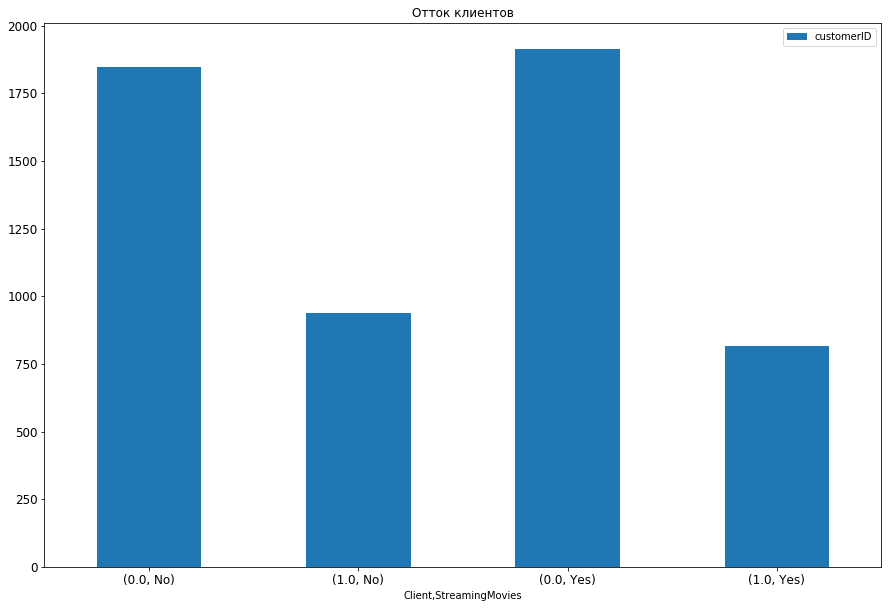

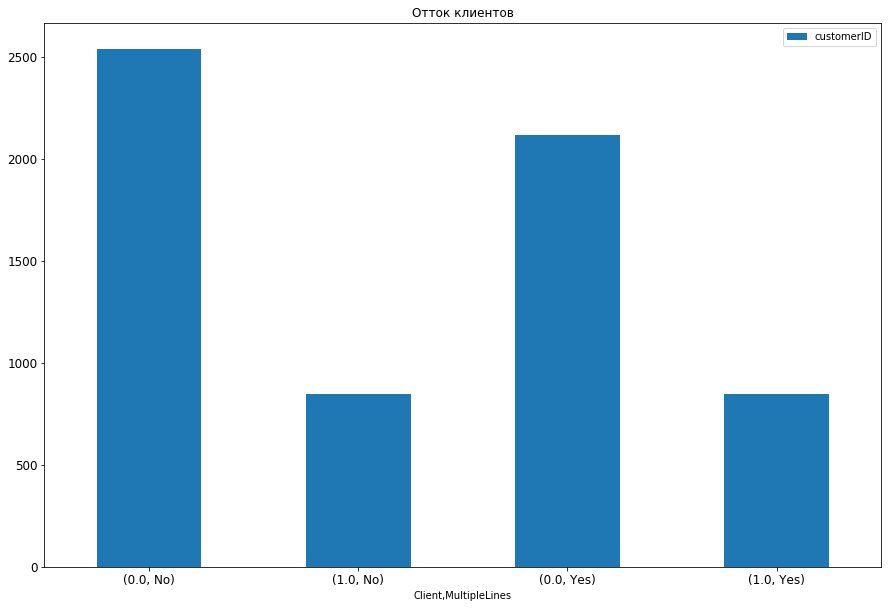

In [13]:
for column_name in ['Type', 'PaperlessBilling','gender','SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'MultipleLines']:
    df_temp=df[[column_name,'Client','customerID']].groupby([column_name,'Client']).count()
    df_temp.reset_index(inplace=True)
    df_temp.set_index(['Client',column_name]).plot.bar(rot=0, title='Отток клиентов', figsize=(15,10), fontsize=12)

На первый взгляд, если на брать во внимание возможные временные границы существования того или иного признака, можно отметить следующее:
- среди долгосрочных договоров (на 1 и 2 года) ушедших клиентов меньше;
- Paperless, SeniorCitizen - сказываются отрицательно;
- пол, MultippleLines, StreamingMovies, - не влияет;
- TechSupport, DeviceProtection,OnlineBackup,OnlineSecurity,DSL InternetService,Dependents,Partner  сказываются положительно.

Добавим признак продолжительности получения услуг. Максимальная дата, дата выгрузки данных, - это 2020-02-02. Поскольку, признак, является ли человек по прежнему клиентом, вынесен в признак Client, можно заменить все No в EndDate на 2020-02-02 для вычисления продолжительности.

In [14]:
 print(df['BeginDate'].sort_values(0))

4513    2013-10-01
4610    2013-10-01
3439    2013-10-01
975     2013-11-01
3040    2013-11-01
           ...    
3331    2020-02-01
6670    2020-02-01
936     2020-02-01
3826    2020-02-01
6754    2020-02-01
Name: BeginDate, Length: 7043, dtype: object


In [15]:
df.loc[contract['EndDate']=='No','EndDate'] = '2020-02-01'
display(df.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Client,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0.0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [16]:
df['Age']=pd.to_datetime(df['EndDate'])-pd.to_datetime(df['BeginDate'])
df['Age'] = df['Age'].dt.days.astype('int16')
display(df.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Client,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Age
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,Female,...,No,DSL,No,Yes,No,No,No,No,NaN,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0.0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,Female,...,No,Fiber optic,No,No,No,No,No,No,No,61


Проведем кодирование строчных признаков

In [17]:
print(df.columns)

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Client', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Age'],
      dtype='object')


In [18]:
ohe_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 
               'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
               'StreamingMovies','MultipleLines']
df_ohe = pd.get_dummies(df.loc[:, ohe_columns], drop_first=True)
df_ohe = pd.get_dummies(df_ohe, drop_first=False)
display(df.head())
print(df.shape)
display(df_ohe.head())
print(df_ohe.shape)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Client,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Age
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,Female,...,No,DSL,No,Yes,No,No,No,No,NaN,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0.0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,Female,...,No,Fiber optic,No,No,No,No,No,No,No,61


(7043, 22)


,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0
2,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0
4,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0


(7043, 18)


In [19]:
# Объединим полученные датафреймы в единый:
df = df.drop(ohe_columns, axis=1)
df = df.drop(['BeginDate','EndDate'], axis=1)
df_ohe.reset_index(drop=True, inplace=True)
df = df.join([df_ohe])
df = df.dropna()
display(df.head())
print(df.info())

,customerID,MonthlyCharges,TotalCharges,Client,Age,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,7590-VHVEG,29.85,29.85,0.0,31,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1,5575-GNVDE,56.95,1889.50,0.0,1036,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,3668-QPYBK,53.85,108.15,1.0,61,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,7795-CFOCW,42.30,1840.75,0.0,1371,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
4,9237-HQITU,70.70,151.65,1.0,61,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
customerID                               7032 non-null object
MonthlyCharges                           7032 non-null float64
TotalCharges                             7032 non-null float64
Client                                   7032 non-null float64
Age                                      7032 non-null int16
SeniorCitizen                            7032 non-null int64
Type_One year                            7032 non-null uint8
Type_Two year                            7032 non-null uint8
PaperlessBilling_Yes                     7032 non-null uint8
PaymentMethod_Credit card (automatic)    7032 non-null uint8
PaymentMethod_Electronic check           7032 non-null uint8
PaymentMethod_Mailed check               7032 non-null uint8
gender_Male                              7032 non-null uint8
Partner_Yes                              7032 non-null uint8
Dependents_Yes                  

In [20]:
# print (df.columns.values.tolist())
for priznak in ['MultipleLines_Yes','StreamingMovies_Yes','StreamingTV_Yes','TechSupport_Yes','DeviceProtection_Yes'
               ,'OnlineBackup_Yes','OnlineSecurity_Yes','InternetService_Fiber optic','Dependents_Yes'
               ,'Partner_Yes','PaymentMethod_Mailed check','PaymentMethod_Electronic check'
                ,'PaymentMethod_Credit card (automatic)','PaperlessBilling_Yes']:
    df_otn = df[['customerID',priznak,'Client']]
    vsego = df_otn[priznak].count()
    print(vsego)
    df_otn_s_uslugoy = df_otn.loc[df_otn[priznak]==1]
    vsego_s_uslugoy = df_otn_s_uslugoy[priznak].count()

    df_otn_bez_uslugi = df_otn.loc[df_otn[priznak]!=1]
    vsego_bez_uslugi = df_otn_bez_uslugi[priznak].count()

    vsego_ushlo = df_otn_s_uslugoy['Client'].sum()
    print(priznak,': доля ушедших клиентов с признаком = ', vsego_ushlo/vsego_s_uslugoy)
    vsego_ushlo2 = df_otn_bez_uslugi['Client'].sum()
    print(priznak,': доля ушедших клиентов без признака = ', vsego_ushlo2/vsego_bez_uslugi)

7032
MultipleLines_Yes : доля ушедших клиентов с признаком =  0.28648466464442196
MultipleLines_Yes : доля ушедших клиентов без признака =  0.25067650676506764
7032
StreamingMovies_Yes : доля ушедших клиентов с признаком =  0.29952398388868545
StreamingMovies_Yes : доля ушедших клиентов без признака =  0.2443617763310858
7032
StreamingTV_Yes : доля ушедших клиентов с признаком =  0.30114687384387717
StreamingTV_Yes : доля ушедших клиентов без признака =  0.2437052437052437
7032
TechSupport_Yes : доля ушедших клиентов с признаком =  0.15196078431372548
TechSupport_Yes : доля ушедших клиентов без признака =  0.31229967948717946
7032
DeviceProtection_Yes : доля ушедших клиентов с признаком =  0.22539288668320925
DeviceProtection_Yes : доля ушедших клиентов без признака =  0.28695275249241436
7032
OnlineBackup_Yes : доля ушедших клиентов с признаком =  0.2156701030927835
OnlineBackup_Yes : доля ушедших клиентов без признака =  0.29216409811156935
7032
OnlineSecurity_Yes : доля ушедших клие

Более 10% разницы между долей ушедших с наличием признака и долей без такого признака наблюдается у следующих признаков:
PaymentMethod_Credit card (automatic), PaymentMethod_Electronic check, PaymentMethod_Mailed check, InternetService_Fiber optic,  OnlineSecurity_Yes, TechSupport_Yes.

In [21]:
df = df.drop(['customerID'], axis=1)

### Сравнение моделей

In [22]:
x = df.drop('Client', axis=1)
y = df['Client']
print(x.shape, y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.25, random_state=123)

(7032, 21) (7032,)


Масштабируем числовые признаки, чтобы приравнять веса признаков.

In [23]:
scaler = MinMaxScaler()
x_train[['MonthlyCharges','TotalCharges','Age']] = scaler.fit_transform(x_train[['MonthlyCharges','TotalCharges','Age']])
display(x_train.head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,MonthlyCharges,TotalCharges,Age,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
1980,0.765820,0.115711,0.127719,0,0,0,1,0,1,0,...,0,0,1,0,1,1,0,0,1,1
5485,0.322372,0.003687,0.000463,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
198,0.935227,0.925785,1.000000,0,0,1,1,0,0,0,...,1,1,1,0,1,1,1,1,1,1
6326,0.251121,0.315013,0.859787,0,0,1,1,1,0,0,...,0,0,0,0,1,1,0,0,1,0
1304,0.669656,0.153098,0.197131,1,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,1,1


In [24]:
x_test[['MonthlyCharges','TotalCharges','Age']] = scaler.transform(x_test[['MonthlyCharges','TotalCharges','Age']])
display(x_test.head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,MonthlyCharges,TotalCharges,Age,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
6830,0.017937,0.076806,0.479870,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
364,0.572995,0.156272,0.240167,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2067,0.844544,0.781635,0.901897,1,1,0,1,0,0,0,...,1,0,1,0,1,1,0,1,1,1
6964,0.377678,0.318694,0.676539,0,1,0,1,1,0,0,...,1,0,0,0,1,0,1,1,1,0
4868,0.808171,0.431941,0.507173,0,0,0,1,0,1,0,...,1,0,1,0,0,1,0,1,1,1


In [25]:
x_train, y_train = upsample(x_train, y_train, 3)

LogisticRegression: ROC AUC=0.856


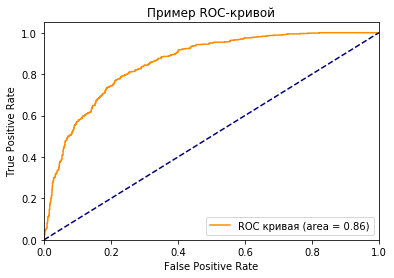

Время выполнения  1.0445301346480846 сек


In [26]:
start_time = default_timer()
model = LogisticRegression(solver='lbfgs')
model.fit(x_train, y_train)
# получаем предказания
lr_probs = model.predict_proba(x_test)
# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()
elapsed = default_timer() - start_time
print('Время выполнения ',elapsed, 'сек')

LogisticRegression: ROC AUC=0.856

In [ ]:
start_time = default_timer()
# param_grid = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4],
#              'max_depth': list(range(1, 200, 4)), 'random_state': [12345], 'bootstrap': [False]}
params = {'max_leaf_nodes': list(range(2, 100, 5)), 'min_samples_split': [2, 3],'max_depth': list(range(1, 50, 2))}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3, scoring='roc_auc')
gs.fit(x_train, y_train)
model = gs.best_estimator_
print(gs.best_params_)
elapsed = default_timer() - start_time
print('Время выполнения ',elapsed, 'сек')

In [27]:
model = DecisionTreeClassifier(max_leaf_nodes= 99,
 min_samples_split= 4,
 max_features= 'sqrt',
 min_samples_leaf= 2,
 max_depth= 13)
model.fit(x_train, y_train) # обучение
y_predict = model.predict_proba(x_test)[:, 1] # предсказание
lr_auc = roc_auc_score(y_test, y_predict)
print('DecisionTreeClassifier: ROC AUC=%.3f' % (lr_auc))

DecisionTreeClassifier: ROC AUC=0.810


{'max_depth': 9, 'max_leaf_nodes': 75, 'min_samples_split': 4}
DecisionTreeClassifier: ROC AUC=0.500

In [ ]:
#from sklearn.model_selection import GridSearchCV
start_time = default_timer()
rfc = RandomForestClassifier()
n_estimators = list(range(300, 600, 50))
max_features = ['sqrt']
max_depth = list(range(1, 100, 5))
min_samples_split = [2,3,4]
min_samples_leaf = [2,3,4]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1, scoring='roc_auc')
gs.fit(x_train, y_train)
rfc_2 = gs.best_estimator_
gs.best_params_
elapsed = default_timer() - start_time
print('Время выполнения ',elapsed, 'сек')

In [ ]:
print(gs.best_params_)

In [28]:
rfc = RandomForestClassifier(bootstrap= False,
 max_depth= 15,
 max_features= 'sqrt',
 min_samples_leaf= 3,
 min_samples_split= 2,
 n_estimators= 500)
rfc.fit(x_train, y_train) # обучение
y_predict = rfc.predict_proba(x_test)[:, 1] # предсказание

In [29]:
lr_auc = roc_auc_score(y_test, y_predict)
print('RandomForestClassifier: ROC AUC=%.3f' % (lr_auc))

RandomForestClassifier: ROC AUC=0.863


RandomForestClassifier: ROC AUC=0.766
Время выполнения  2663.5532384 сек...стало RandomForestClassifier: ROC AUC=0.594

In [ ]:
start_time = default_timer()

max_depth = list(range(1, 100, 3))
n_estimators = list(range(1, 200, 3))
boosting_type=['gbdt']
objective='regression'
num_leaves=list(range(50, 100, 55))
learning_rate=[0.08]
bagging_fraction=[0.8]
feature_fraction=[0.8]
reg_lambda=[0.9]
LGBM = LGBMClassifier()
param_grid = {'n_estimators': n_estimators,'num_leaves': num_leaves,
               'max_features': max_features,'reg_lambda': reg_lambda,
               'max_depth': max_depth,'bagging_fraction': bagging_fraction,
               'bootstrap': bootstrap,'learning_rate': learning_rate,
               'num_leaves': num_leaves,'boosting_type': boosting_type,
}
gs = GridSearchCV(LGBM, param_grid,  cv = 3, verbose = 1, n_jobs=-1, scoring='roc_auc')
gs.fit(x_train, y_train)
LGBM_2 = gs.best_estimator_
print(gs.best_params_)
elapsed = default_timer() - start_time
print('Время выполнения ',elapsed, 'сек')

In [30]:
lgbm = LGBMClassifier(
    bootstrap= False,
 max_depth= 17,
 max_features= 'sqrt',
 n_estimators= 97
)
lgbm.fit(x_train, y_train) # обучение
y_predict = lgbm.predict_proba(x_test)[:, 1] # предсказание
lr_auc = roc_auc_score(y_test, y_predict)
print('LGBMClassifier: ROC AUC=%.3f' % (lr_auc))

LGBMClassifier: ROC AUC=0.908


{'bootstrap': False, 'max_depth': 17, 'max_features': 'sqrt', 'n_estimators': 97}
LGBMClassifier: ROC AUC=0.819

In [ ]:
#lgbm = LGBMRegressor(
#    bootstrap= False,
# max_depth= 17,
# max_features= 'sqrt',
# n_estimators= 97
#)
#lgbm.fit(x_train, y_train) # обучение
#y_predict = lgbm.predict(x_test) # предсказание
#lr_auc = roc_auc_score(y_test, y_predict)
#print('LGBMRegressor: ROC AUC=%.3f' % (lr_auc))

LGBMRegressor: ROC AUC=0.909

### Вывод

Можно выделить услуги, с которыми доля ушедших клиентов больше, чем без данной услуги. Это PaymentMethod_Credit card (automatic), PaymentMethod_Electronic check, PaymentMethod_Mailed check, InternetService_Fiber optic, OnlineSecurity_Yes, TechSupport_Yes.

Лучший достигнутый результат auc_roc =0.909 на модели LGBMRegressor: ROC AUC=0.909 позволит относительно точно предлагать таким клиентам как бонусы, так и переход на более "положительные" типы услуг, с использованием которых расстается меньшая доля клиентов.